In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import GridSearchCV


ModuleNotFoundError: No module named 'train_set'

In [3]:
# X includes the chromosome data
X = Training_set.iloc[:, :-1]
# Y has the last col with labels
Y = Training_set.iloc[:, -1]

NameError: name 'Training_set' is not defined

[0.17064204 0.05147376]


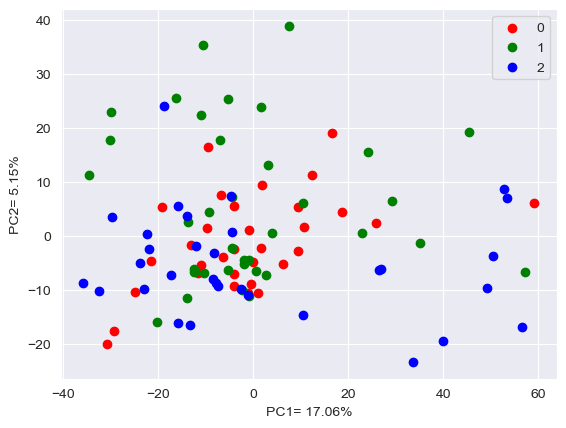

In [5]:
scaler = StandardScaler()
label_encoder = LabelEncoder()
X_scaled = scaler.fit_transform(X)
# 2 principle components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
# to see how much each pc explains
print(pca.explained_variance_ratio_)

# treate a new DataFrame that includes the PCA results and the labels
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'], index=X.index)

# needed to decode the labels for the legend and colors
Y_encoded = label_encoder.fit_transform(Y)
pca_df['label'] = Y_encoded

# colors for the labels
color_map = {
    0: 'r',  # HER2+
    1: 'g',  # HR+
    2: 'b'  # Triple Neg
}

# scatter plot of the first two PCs
fig, ax = plt.subplots()
for label, color in color_map.items():
    mask = pca_df['label'] == label
    ax.scatter(pca_df.loc[mask, 'PC1'], pca_df.loc[mask, 'PC2'], c=color, label=label)
ax.legend()
ax.set_xlabel('PC1= 17.06%')
ax.set_ylabel('PC2= 5.15%')
plt.show()
pca_df['label'] = label_encoder.inverse_transform(pca_df['label'])




In [6]:
print(pca_df)
Xpca = pca_df.iloc[:, :-1]
# Y has the last col with labels
Ypca = pca_df.iloc[:, -1]
Xpca.head()

                 PC1        PC2       label
Array.129  -0.135901  -4.801678       HER2+
Array.34   -9.414722   4.350806         HR+
Array.67  -20.225184 -15.973809         HR+
Array.24  -29.699002   3.444851  Triple Neg
Array.22   -4.423731   0.751077  Triple Neg
...              ...        ...         ...
Array.10  -19.334849   5.345068       HER2+
Array.123  -7.057250  17.786805         HR+
Array.100  -0.945248 -11.046797         HR+
Array.134   7.586307  38.877505         HR+
Array.130   0.987908 -10.647975       HER2+

[100 rows x 3 columns]


,PC1,PC2
Array.129,-0.135901,-4.801678
Array.34,-9.414722,4.350806
Array.67,-20.225184,-15.973809
Array.24,-29.699002,3.444851
Array.22,-4.423731,0.751077


In [7]:
Xpca_train, Xpca_test, Ypca_train, Ypca_test = train_test_split(Xpca, Ypca, test_size=0.2, random_state=42)
# Define the parameter grid to search over , Here we want to find optimal parameters for our random forest model
param_grid = {'n_estimators': [50, 100, 200],
              'max_depth': [5, 10, 20],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]
              }

# Define the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Use GridSearchCV to search over the parameter grid
grid_search = GridSearchCV(rf_model, param_grid=param_grid, cv=5)

# Fit the grid search to the training data
grid_search.fit(Xpca_train, Ypca_train)

# Print the best hyperparameters
print("Best hyperparameters: ", grid_search.best_params_)

Best hyperparameters:  {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}


In [8]:
#train the classifier
clf = RandomForestClassifier(max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=100, random_state=42)

clf.fit(Xpca_train, Ypca_train)
# evaluate the accuracy of it

Ypca_pred = clf.predict(Xpca_test)
accuracy = accuracy_score(Ypca_test, Ypca_pred)
precision = metrics.precision_score(Ypca_test, Ypca_pred, average='macro')
recall = metrics.recall_score(Ypca_test, Ypca_pred, average='macro')
f1_score = metrics.f1_score(Ypca_test, Ypca_pred, average='macro')
print("With rfe feature selection:")
print(f'Accuracy: {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1-score: {f1_score:.3f}')
# Stratified 10-fold cross-validation so each fold will have a representative proportion of each class

With rfe feature selection:
Accuracy: 0.600
Precision: 0.605
Recall: 0.603
F1-score: 0.595


In [10]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
accuracy_scores = []

Xfold = Xpca[["PC1", "PC2"]].values

# loop over each fold ( fold= fold counter), train & test indices of the samples in each fold
for fold, (train_index, test_index) in enumerate(skf.split(Xfold, Ypca)):
    Xfold_train, Xfold_test = Xfold[train_index], Xfold[test_index]
    Yfold_train, Yfold_test = Y[train_index], Y[test_index]

    # Train the classifier on the training data
    clf.fit(Xfold_train, Yfold_train)

    # Test the classifier on the test data
    y_pred = clf.predict(Xfold_test)

    # Compute the accuracy score and append it to the list of scores
    score = accuracy_score(Yfold_test, y_pred)
    accuracy_scores.append(score)

# Calculate the mean accuracy score and its standard deviation
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)
print("Mean accuracy: {:.2f}%".format(mean_accuracy * 100))
print("Standard deviation: {:.2f}%".format(std_accuracy * 100))

Mean accuracy: 42.00%
Standard deviation: 14.00%
